## Phase 3 — Exploratory Data Analysis (EDA)

Purpose: turn the cleaned & engineered dataset into concise, business-grade insights. Produce repeatable outputs (tables, figures, a short narrative) that answer the stakeholder questions we agreed on (stocking, discontinuation, quality, discount effectiveness).

OVERALL GAMEPLAN (order of execution)

1. Brand Performance Analysis (ranking + validation)

2. Category Insights (aggregations by category_group)

3. Price-Tier & Discount Analysis (price_tier × discount_tier × sentiment)

4. Discount Effectiveness (do deeper discounts improve sentiment/ratings?)

5. Ultra-Discount Deep Dive (inspect ultra_discount cases individually)

6. Sentiment vs Rating Alignment (text vs numeric consistency check)

7. Final packaging: visuals, tables, and executive summary

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as mlt
import seaborn as sns

In [2]:
df_3 = pd.read_csv("/workspaces/Amazon-Sales-data-analysis/notebooks/cleaned_data_2.csv") 
df_3.head()

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,review_id,...,discount_percentage_num,discount_ratio,price_difference,ultra_discount,brands,price_tier,discount_tier,pos_word,neg_word,customer_sentiment
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories,399.0,1099.0,64%,4.2,24269.0,High Compatibility : Compatible With iPhone 12...,"R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...",...,64,0.363057,700.0,False,Wayona,Mid,High,True,False,satisfied
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories,199.0,349.0,43%,4.0,43994.0,"Compatible with all Type C enabled devices, be...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...",...,43,0.570201,150.0,False,Ambrane,Low,Mid,True,True,Mixed
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories,199.0,1899.0,90%,3.9,7928.0,【 Fast Charger& Data Sync】-With built-in safet...,"R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...",...,90,0.104792,1700.0,False,Sounce,Mid,High,True,False,satisfied
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories,329.0,699.0,53%,4.2,94363.0,The boAt Deuce USB 300 2 in 1 cable is compati...,"R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...",...,53,0.470672,370.0,False,boAt,Low,Mid,True,True,Mixed
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories,154.0,399.0,61%,4.2,16905.0,[CHARGE & SYNC FUNCTION]- This cable comes wit...,"R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...",...,61,0.385965,245.0,False,Portronics,Low,High,True,True,Mixed


### 1. BRAND PERFORMANCE   

**Goal: surface brands to promote, partner with, or monitor.**

What to compute (brand-level):
 
- n_reviews_brand = total reviews across brand (sum of rating_count or count of review rows).

- avg_rating_brand = mean rating across all brand reviews.

- rating_index = Balancing avg_rating_brand with volume of ratings by using a log transform.

- percent_satisfied_brand = total satisfied reviews / total reviews for brand.

- percent_dissatisfied_brand = total dissatisfied reviews / total reviews for brand.

- satisfaction_index 


**How to rank / filters:**

Ignore brands with very low sample (set a threshold, e.g., n_reviews_brand >= 10).

**Create lists:**

- Top brands: high avg_rating_brand, high percent_satisfied_brand, healthy n_reviews_brand.

- Top trusted brands : high rating_index = mean_rating * np.log1p(total_rating_count)  

- At-risk brands: high discounts + low satisfaction or low avg_rating.

**Validation check**

- Confirm brand extraction correctness (manual sample of 20 names to catch false positives like "The", "New", etc.).

**Suggested visuals & deliverables:**

- Bar: Top 10 brands by avg_rating_brand (filename: reports/brands_top10_rating.png)

- Scatter: avg_rating_brand vs n_reviews_brand (bubble=size=revenue_proxy) (reports/brands_rating_vs_volume.png)

- CSV: reports/brands_summary.csv

Narration excerpt:
“Brand X leads in satisfaction with Y% satisfied and strong volume; Brand Z requires attention — high discounting but low satisfaction suggesting quality or listing issues.

In [3]:
# total number of times each brands was mentioned 
df_3["brands"].value_counts() 

brands
boAt            67
Samsung         36
AmazonBasics    33
Portronics      31
Ambrane         29
                ..
KONVIO           1
Raffles          1
KNYUC            1
INKULTURE        1
Macmillan        1
Name: count, Length: 437, dtype: int64

**TOTAL REVIEWS ACROSS BRANDS**

In [4]:
# Grouping of each respective brands in respect to its total amount of reviews 
brands_rev = df_3.groupby("brands", as_index=False).agg(total_reviews = ("rating_count", "sum")).sort_values("total_reviews", ascending=False) 
n_reviews_brand = brands_rev.reset_index(drop=True).head(10)

#List of top 10 brands with the highest reviews across the dataframe 
n_reviews_brand

,brands,total_reviews
0,boAt,4416568.0
1,Redmi,1878482.0
2,AmazonBasics,1808818.0
3,SanDisk,1426074.0
4,Amazon,1213138.0
5,TP-Link,1027849.0
6,Samsung,901882.0
7,JBL,891075.0
8,MI,774818.0
9,Noise,621421.0


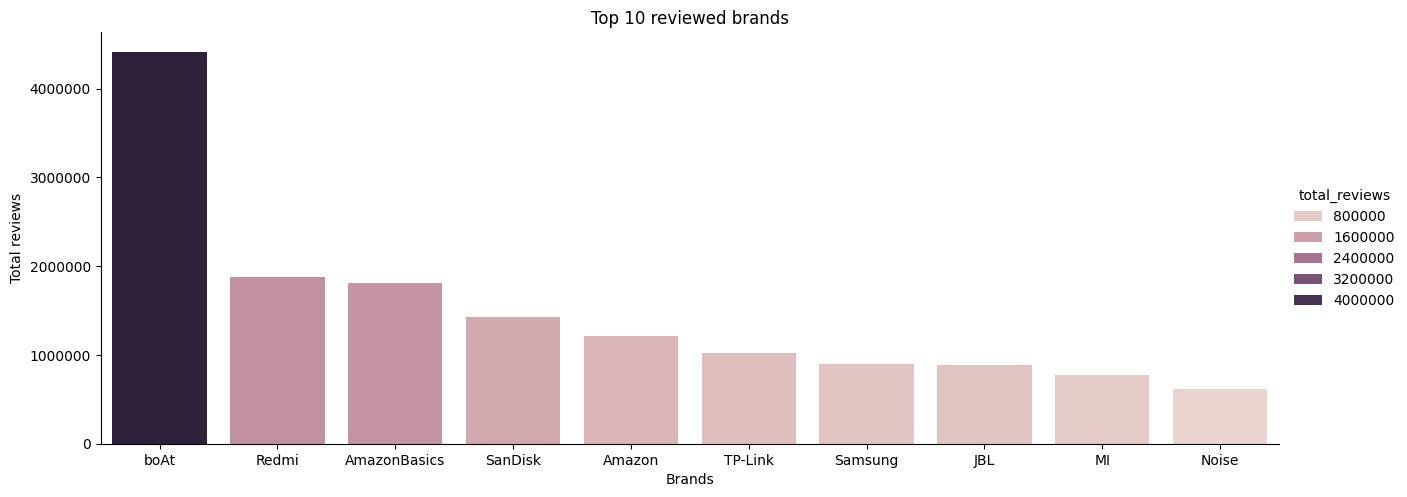

In [11]:
sns.catplot(y="total_reviews", x="brands", hue="total_reviews",data=n_reviews_brand,aspect=2.5,kind="bar")
plt.ticklabel_format(style='plain', axis='y') 
plt.xlabel("Brands")
plt.ylabel("Total reviews")
plt.title("Top 10 reviewed brands")
plt.show()

**AVERAGE RATINGS ACROSS BRANDS IN RESPECT TO RATING INDEX**

In [12]:
# Averages of the total ratings present within each brands 
brands = (df_3.groupby("brands")
            .agg(mean_rating=("rating", "mean"),total_reviews=("rating_count", "sum"))
            .query("total_reviews >= 10").reset_index()
)            

# Result bias: Larger brands with tons of ratings dominate,but smaller ones with very few ratings can’t shoot up unfairly.
# I need to balances mean rating with scale of reviews using a log transform.
brands["rating_index"] = (brands["mean_rating"] * np.log1p(brands["total_reviews"]))

brand_rating = brands.sort_values("rating_index", ascending=False).reset_index(drop=True).head(10) 
brand_rating

,brands,mean_rating,total_reviews,rating_index
0,boAt,4.080597,4416568.0,62.436700
1,AmazonBasics,4.306061,1808818.0,62.042517
2,SanDisk,4.370588,1426074.0,61.933143
3,TP-Link,4.317647,1027849.0,59.769101
4,Redmi,4.053846,1878482.0,58.561761
5,Amazon,4.140000,1213138.0,57.996108
6,MI,4.271429,774818.0,57.922215
7,Samsung,4.202778,901882.0,57.629498
8,Logitech,4.380000,349817.0,55.911437
9,Fire-Boltt,4.230769,536078.0,55.812463


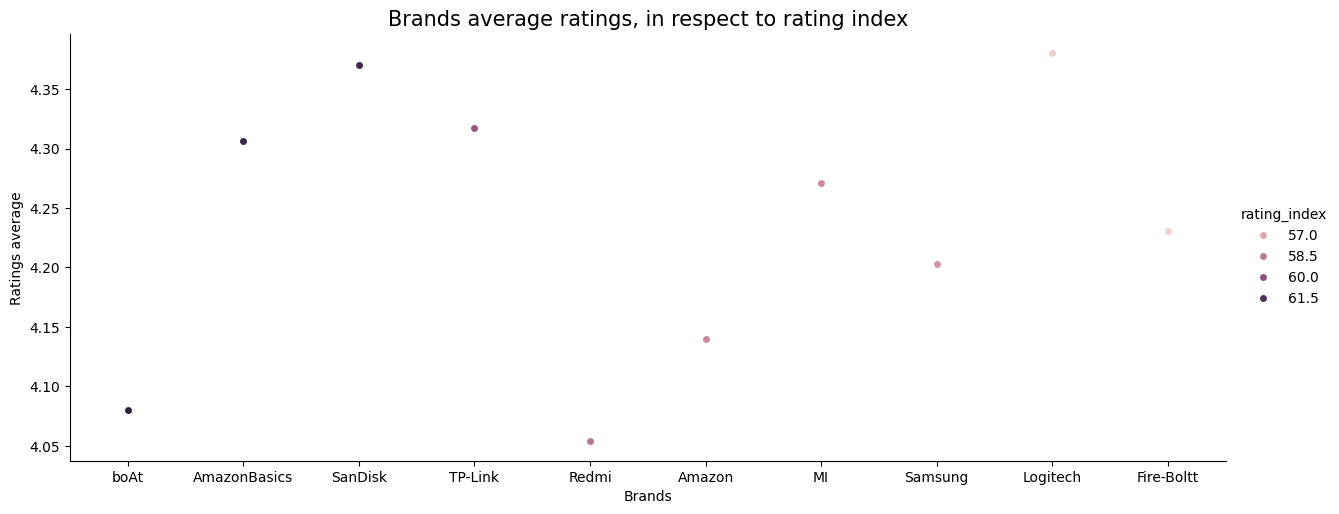

In [31]:
sns.catplot(y = "mean_rating", x = "brands", hue = "rating_index", data = brand_rating, aspect=2.5)
plt.xlabel("Brands", fontsize = 10)
plt.ylabel("Ratings average", fontsize = 10) 
plt.title("Brands average ratings, in respect to rating index", fontsize = 15)
plt.show()

In [28]:
# Saving brands rating to a new csv file
df_3.to_csv("brand_rating.csv", index=False)

**BRANDS SATISFACTORY INDEX**

In [18]:
# Mapping sentiments to numerical representations
mapping = {"satisfied": 1.0, "Mixed": 0, "dissatisfied": -1.0}
df_3["sentiment_value"] = df_3["customer_sentiment"].map(mapping) 

In [19]:
brand_sentiment = (df_3.groupby("brands")
                  .agg(total_satisfied=("sentiment_value", lambda x: (x == 1).sum()),
                       total_sentiment_score =("sentiment_value", "count"))
                  .query("total_sentiment_score >= 10")      
)           
# Storing the percentage of satisfied customer in a variable        
satisfied_percent = brand_sentiment["total_satisfied"] / brand_sentiment["total_sentiment_score"] * 100
                                                                     
# Final Satisfaction Scoring metric for brands    
brand_sentiment["satisfaction_index"] = satisfied_percent * np.log1p(brand_sentiment["total_sentiment_score"])

# Top Brands with the most satisfied customer
Top_satisfied_brands = brand_sentiment.sort_values("satisfaction_index", ascending=False).reset_index().head(10)

Top_satisfied_brands

,brands,total_satisfied,total_sentiment_score,satisfaction_index
0,AmazonBasics,25,33,267.148525
1,pTron,13,13,263.905733
2,Duracell,15,20,228.339183
3,Noise,17,24,228.003704
4,Wayona,17,24,228.003704
5,Portronics,20,31,223.595865
6,STRIFF,9,11,203.310544
7,Classmate,9,11,203.310544
8,Bajaj,15,24,201.179739
9,AGARO,10,14,193.432157


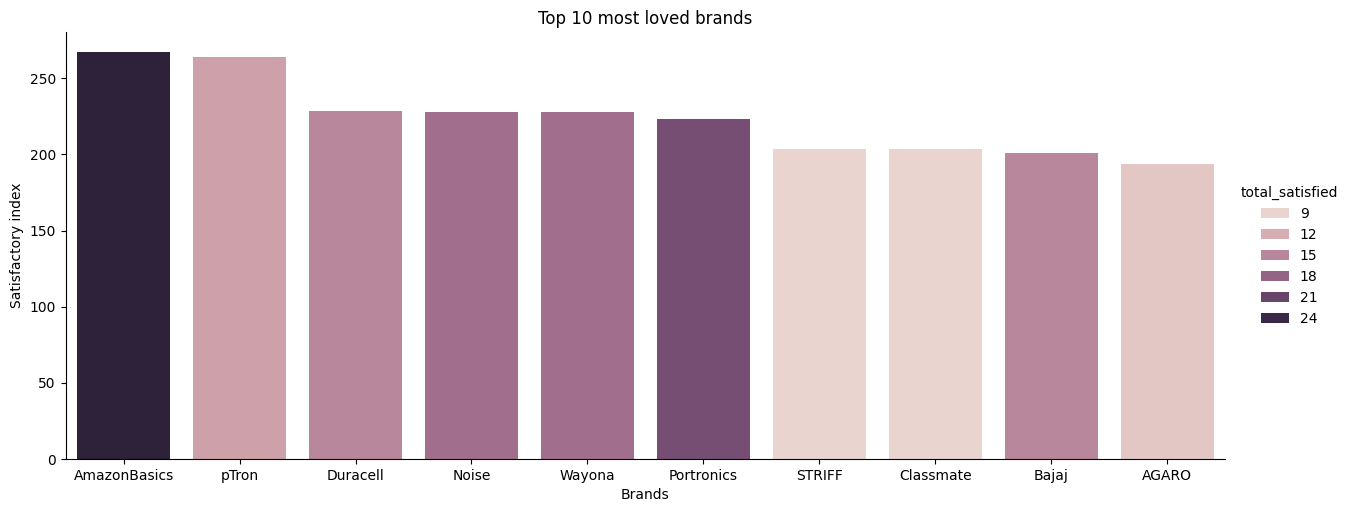

In [21]:
sns.catplot(x="brands", y="satisfaction_index", data = Top_satisfied_brands, hue = "total_satisfied", aspect = 2.5, kind = "bar")
plt.ticklabel_format(style="plain", axis = "y")
plt.xlabel("Brands")
plt.ylabel("Satisfactory index")
plt.title("Top 10 most loved brands")
plt.show()

In [23]:
# Saving Top satisifed brands to a new csv
df_3.to_csv("Top_satisfied_brands.csv", index=False)

### 2. CATEGORY INSIGHTS 
***Compute per category_group:*** 
- n_reviews_category = total ratings across category (sum of rating_count or count of review rows).

- avg_rating_category = mean rating across all category reviews.

- rating_index

- percent_satisfied_category = total satisfied reviews / total reviews for category.

- percent_dissatisfied_category = total dissatisfied reviews / total reviews for category

- Satisfaction_index = (positives − negatives) ÷ total reviews.


***Deliverables:***

- CSV: reports/category_summary.csv

- Heatmap: satisfaction_index vs price_tier

- Bar: Top 10 categories by satisfaction_index

Narration line:
“Electronics and Storage Devices lead in both review volume and satisfaction; Mobile Accessories lag behind with heavy discounting but low sentiment.”

In [32]:
df_3["category"].unique()

array(['Computers&Accessories', 'Electronics', 'MusicalInstruments',
       'OfficeProducts', 'Home&Kitchen', 'HomeImprovement', 'Toys&Games',
       'Car&Motorbike', 'Health&PersonalCare'], dtype=object)

In [33]:
# Total number of reviews across each categories
n_reviews_category = (df_3.groupby("category")
                     .agg(total_reviews = ("rating_count", sum))        
                     .sort_values("total_reviews", ascending = False)
                     .reset_index() 
)

n_reviews_category


/tmp/ipykernel_13531/2808139295.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg(total_reviews = ("rating_count", sum))


,category,total_reviews
0,Electronics,15778848.0
1,Computers&Accessories,7739047.0
2,Home&Kitchen,2991069.0
3,OfficeProducts,149675.0
4,MusicalInstruments,88882.0
5,Toys&Games,15867.0
6,HomeImprovement,8566.0
7,Health&PersonalCare,3663.0
8,Car&Motorbike,1118.0


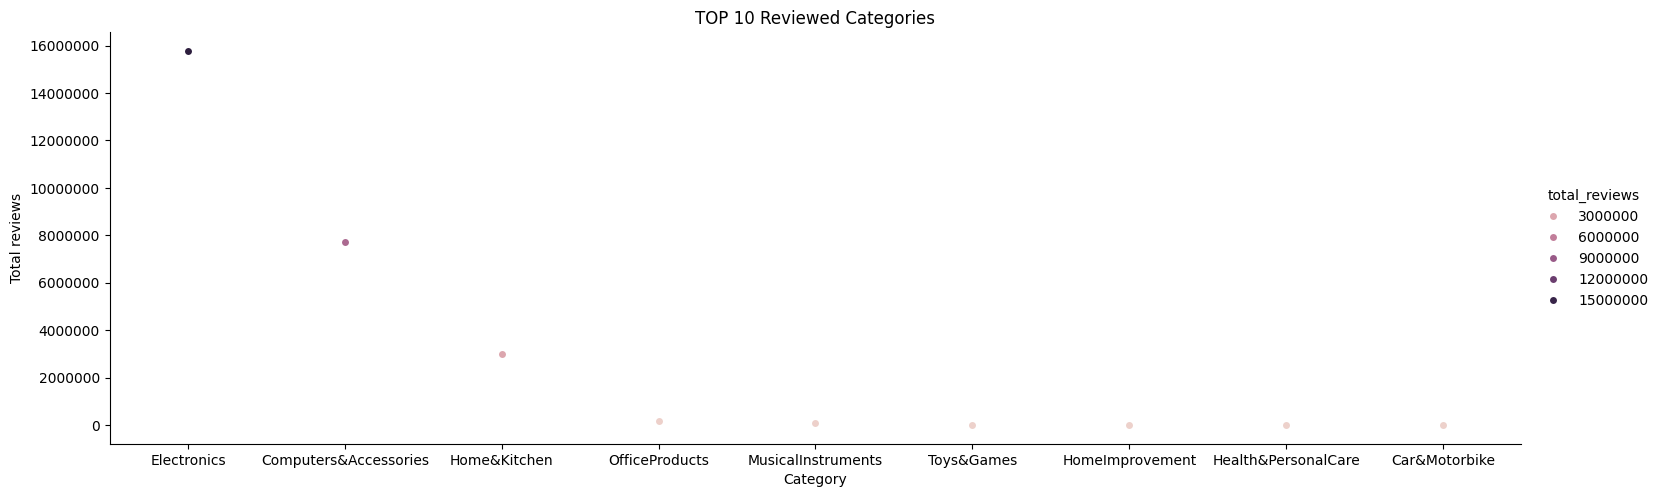

In [42]:
sns.catplot(y = "total_reviews", x = "category", hue = "total_reviews", data = n_reviews_category, aspect = 3.0)
plt.ticklabel_format(style="plain", axis="y")
plt.xlabel("Category")
plt.ylabel("Total reviews")
plt.title("TOP 10 Reviewed Categories") 
plt.show()

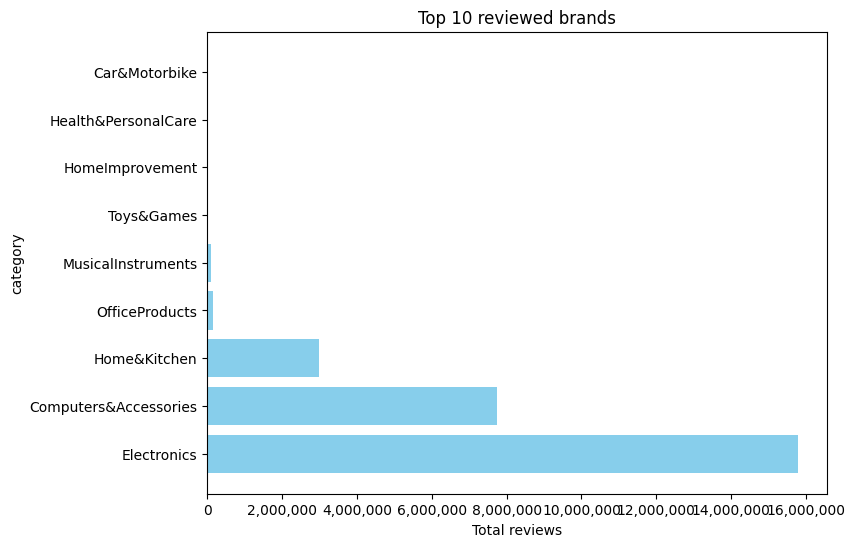

In [45]:
fig, ax = plt.subplots( figsize = (8,6)) 
ax.barh(n_reviews_category["category"], n_reviews_category["total_reviews"], align = "center", color = "skyblue")
ax.xaxis.set_major_formatter(mlt.FuncFormatter(lambda x, _: f"{int(x):,}"))
ax.set_ylabel("category") 
ax.set_xlabel("Total reviews") 
ax.set_title("Top 10 reviewed brands") 

plt.show()

In [15]:
# Mean ratings across each categories
# What it does: Just takes the arithmetic mean of ratings per category.
avg_rating_category = (df_3.groupby("category")
                     .agg(Average_rating = ("rating", "mean"))        
                     .sort_values("Average_rating", ascending = False)
                     .reset_index() 
)

# "Result bias: Categories with small review counts can float to the top if their handful of reviews happen to be good."
avg_rating_category


,category,Average_rating
0,OfficeProducts,4.309677
1,Toys&Games,4.300000
2,HomeImprovement,4.250000
3,Computers&Accessories,4.154967
4,Electronics,4.081749
5,Home&Kitchen,4.042857
6,Health&PersonalCare,4.000000
7,MusicalInstruments,3.900000
8,Car&Motorbike,3.800000


In [9]:
# What it does: Balances mean rating with scale of reviews using a log transform.
category = df_3.groupby("category").agg(mean_rating=("rating", "mean"),total_reviews=("rating_count", "sum")).reset_index()

# Result bias: Larger categories with tons of ratings dominate (Electronics, Computers),
# but smaller ones with very few ratings can’t shoot up unfairly.
category["rating_index"] = (category["mean_rating"] * np.log1p(category["total_reviews"]))

avg_category_ratings = category.sort_values("rating_index", ascending=False).reset_index(drop=True)

avg_category_ratings


,category,mean_rating,total_reviews,rating_index
0,Electronics,4.081749,15778848.0,67.651647
1,Computers&Accessories,4.154967,7739047.0,65.905209
2,Home&Kitchen,4.042857,2991069.0,60.283616
3,OfficeProducts,4.309677,149675.0,51.355100
4,MusicalInstruments,3.900000,88882.0,44.440797
5,Toys&Games,4.300000,15867.0,41.589857
6,HomeImprovement,4.250000,8566.0,38.486610
7,Health&PersonalCare,4.000000,3663.0,32.825243
8,Car&Motorbike,3.800000,1118.0,26.676725


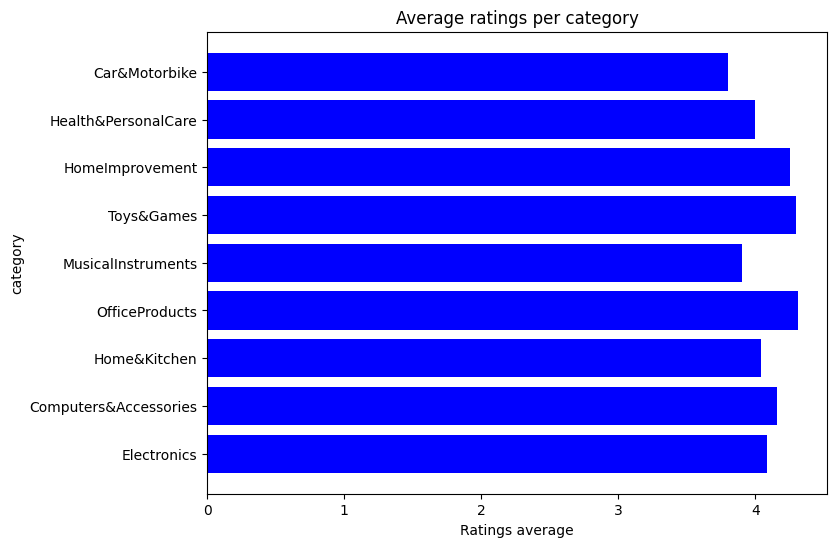

In [11]:
fig, ax = plt.subplots( figsize = (8,6)) 
ax.barh(avg_category_ratings["category"], avg_category_ratings["mean_rating"], align = "center", color = "blue")
ax.xaxis.set_major_formatter(mlt.FuncFormatter(lambda x, _: f"{int(x):,}"))
ax.set_ylabel("category") 
ax.set_xlabel("Ratings average") 
ax.set_title("Average ratings per category") 

plt.show()

In [ ]:
# Saving the average ratings of each category to a new csv
df_3.to_csv("avg_category_ratings.csv", index=False)

In [12]:
category_sentiment = (df_3.groupby("category")
                  .agg(total_satisfied=("sentiment_value", lambda x: (x == 1).sum()),
                       total_sentiment_score=("sentiment_value", "count"))
                  .query("total_sentiment_score >= 10")      
)           
# Storing the percentage of satisfied customer in a variable        
percent_satisfied_category = (category_sentiment["total_satisfied"] / category_sentiment["total_sentiment_score"] * 100)
                                                                     
# Final Satisfaction Scoring metric for each categories   
category_sentiment["satisfaction_index"] = percent_satisfied_category * np.log1p(category_sentiment["total_sentiment_score"])

# Top categories with the most satisfied customer
top_satisfied_category = category_sentiment.sort_values("satisfaction_index", ascending=False).reset_index()

top_satisfied_category

,category,total_satisfied,total_sentiment_score,satisfaction_index
0,Computers&Accessories,291,448,396.683853
1,Home&Kitchen,258,437,359.087524
2,Electronics,226,521,271.445849
3,OfficeProducts,22,30,251.825728


In [15]:
top_satisfied_category["category"]

0    Computers&Accessories
1             Home&Kitchen
2              Electronics
3           OfficeProducts
Name: category, dtype: object

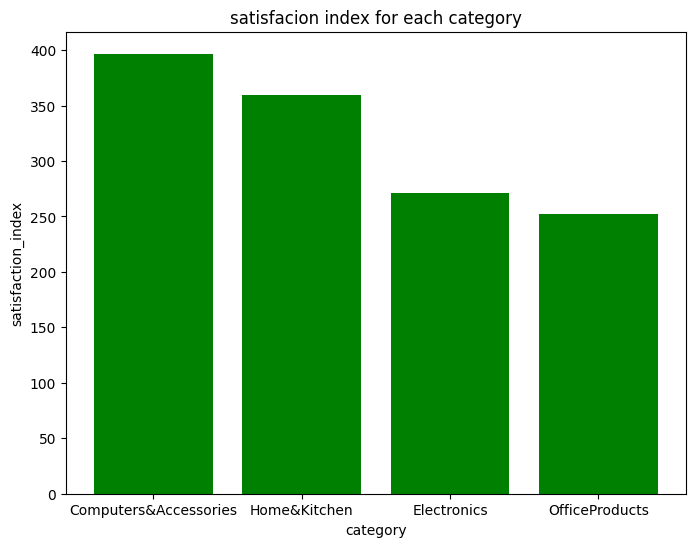

In [22]:
fig, ax = plt.subplots( figsize = (8,6)) 
ax.bar(top_satisfied_category["category"], top_satisfied_category["satisfaction_index"],color = "green")
ax.set_ylabel("satisfaction_index") 
ax.set_xlabel("category") 
ax.set_title("satisfacion index for each category") 

plt.show()

In [50]:
# Saving Top satisifed categories to a new csv
df_3.to_csv("top_satisfied_category.csv", index=False)


### 3) Price Tier Analysis

**Goal: Test if value perception changes across price bands.**

**Metrics per price_tier:**

- avg_rating, 

- satisfaction_index, 


**Deliverables:** 

CSV: reports/price_tier_summary.csv

Boxplot: rating distribution per price_tier

**Narration line:**
“Mid-tier products ($20–$50) show the highest satisfaction_index. Ultra-low tiers underperform despite high volumes.”

In [45]:
# Mean ratings across each price tiers
# What it does: Just takes the arithmetic mean of ratings per category.
avg_rating = (df_3.groupby("price_tier")
                     .agg(Average_rating = ("rating", "mean"),total_reviews = ("rating_count", sum))                       
                     .sort_values("Average_rating", ascending = False)
                     .reset_index() 
)

avg_rating

/tmp/ipykernel_13531/2756008042.py:4: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg(Average_rating = ("rating", "mean"),total_reviews = ("rating_count", sum))


,price_tier,Average_rating,total_reviews
0,High,4.105738,8556346.0
1,Mid,4.104933,8563437.0
2,Low,4.082863,9656952.0


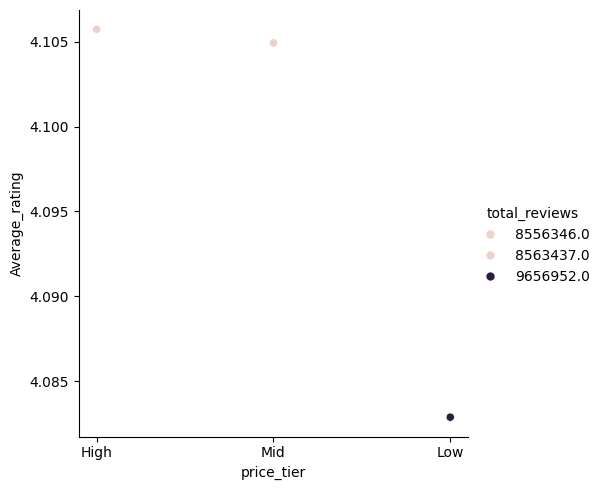

In [46]:
sns.relplot(data=avg_rating, x="price_tier", y="Average_rating", hue="total_reviews")

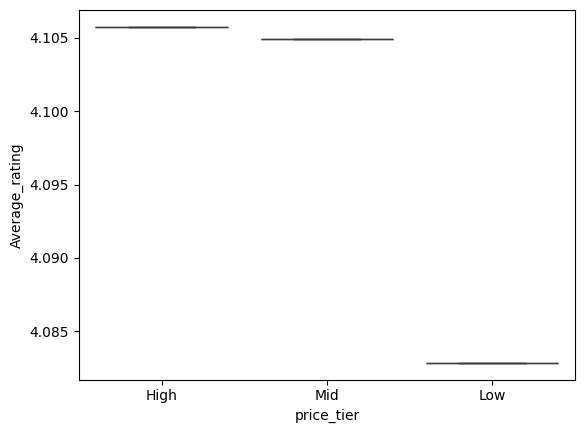

In [18]:
sns.boxplot(x='price_tier', y='Average_rating', data=avg_rating)
plt.show()

In [41]:
price_sentiment = (df_3.groupby("price_tier")
                  .agg(total_satisfied=("sentiment_value", lambda x: (x == 1).sum()),total_sentiment_score=("sentiment_value", "count"))
                  .query("total_sentiment_score >= 10")      
)           
# Storing the percentage of satisfied customer in a variable        
price_satisfied_prcnt = (price_sentiment["total_satisfied"] / price_sentiment["total_sentiment_score"] * 100)
                                                                     
# Final Satisfaction Scoring metric for each price tier   
price_sentiment["satisfactory_index"] = price_satisfied_prcnt * np.log1p(price_sentiment["total_sentiment_score"])

# Price Tier with the most satisfied customer
satisfaction_index = price_sentiment.sort_values("satisfactory_index", ascending=False).reset_index()

satisfaction_index

,price_tier,total_satisfied,total_sentiment_score,satisfactory_index
0,Low,333,523,398.676239
1,Mid,250,438,347.288779
2,High,217,482,278.228966


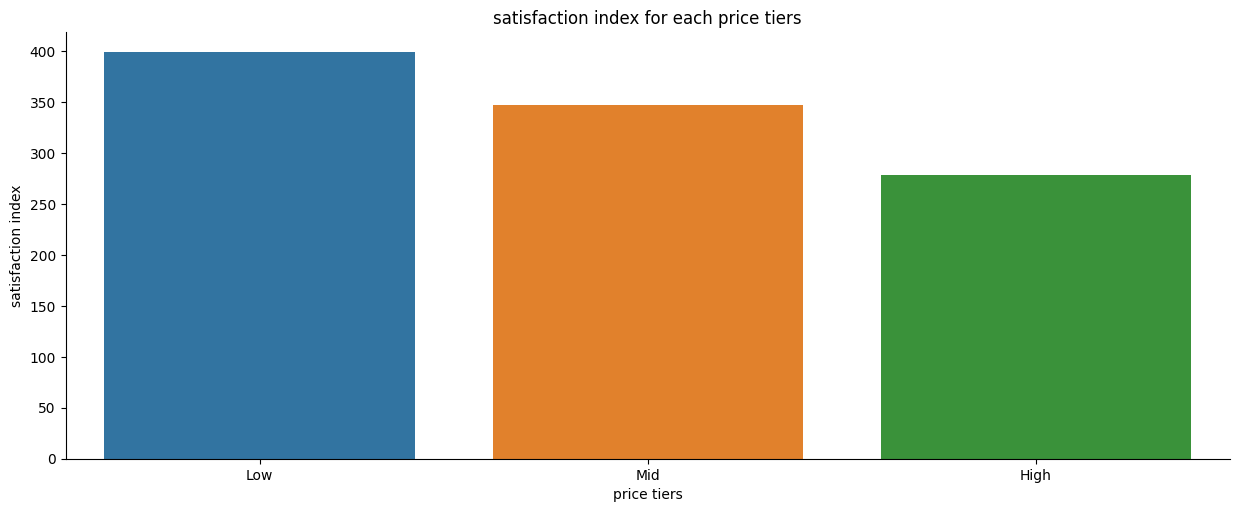

In [43]:
sns.catplot(y="satisfactory_index", x="price_tier", hue="price_tier", data=satisfaction_index, aspect=2.5, kind="bar")
plt.xlabel("price tiers")
plt.ylabel("satisfaction index")
plt.title("satisfaction index for each price tiers") 
plt.show()


### 4) Discount Effectiveness

**Goal: Measure if discounts actually improve satisfaction.**

**Analysis:**

- Group by discount_tier and compare performance.

**Deliverables:**

- CSV: reports/discount_effectiveness.csv

- Scatter: discount_ratio vs avg_rating

**Narration line:**
“Discounts above 50% show diminishing returns — products appear over-discounted and fail to boost satisfaction.”

In [29]:
# Mean ratings across each discount tiers
# What it does: Just takes the arithmetic mean of ratings per category.
discount_avg_rating = (df_3.groupby("discount_tier")
                     .agg(rating_averages = ("rating", "mean"),total_rating_count = ("rating_count", sum))                      
                     .sort_values("rating_averages", ascending = False)
                     .reset_index() 
)

discount_avg_rating 

/tmp/ipykernel_8963/2237623272.py:4: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg(rating_averages = ("rating", "mean"),total_rating_count = ("rating_count", sum))


,discount_tier,rating_averages,total_rating_count
0,Low,4.147755,8799711.0
1,Mid,4.079291,8595314.0
2,High,4.062642,9381710.0


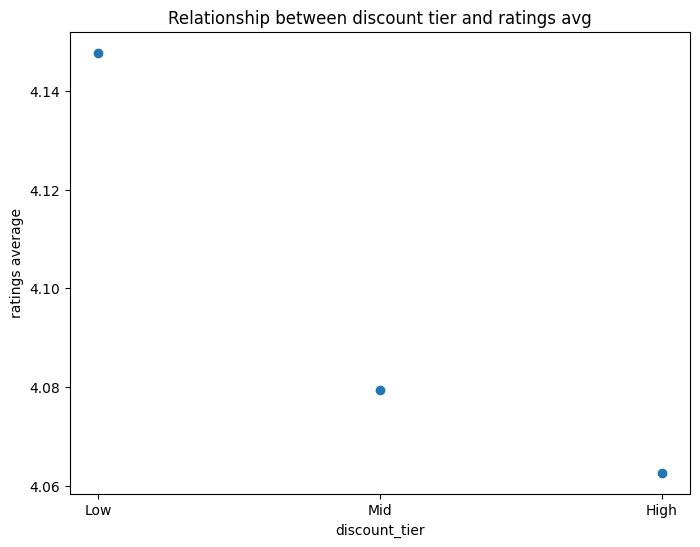

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(discount_avg_rating["discount_tier"], discount_avg_rating["rating_averages"])
ax.set_ylabel("ratings average")
ax.set_xlabel("discount_tier")
ax.set_title("Relationship between discount tier and ratings avg")

plt.show()

In [34]:
discount_sentiment = (df_3.groupby("discount_tier")
                  .agg(total_satisfied=("sentiment_value", lambda x: (x == 1).sum()),
                        total_sentiment_score=("sentiment_value", "count"))
                  .query("total_sentiment_score >= 10")      
)           
# Storing the percentage of satisfied customer in a variable        
satisfied_prcnt = (discount_sentiment["total_satisfied"] / discount_sentiment["total_sentiment_score"] * 100)
                                                                     
# Final Satisfaction Scoring metric for each price tier   
discount_sentiment["satisfactory_index"] = satisfied_prcnt * np.log1p(discount_sentiment["total_sentiment_score"])

# Price Tier with the most satisfied customer
discount_effectiveness = discount_sentiment.sort_values("satisfactory_index", ascending=False).reset_index()

discount_effectiveness 

,discount_tier,total_satisfied,total_sentiment_score,satisfactory_index
0,High,270,435,377.232967
1,Mid,301,526,358.636381
2,Low,229,482,293.614899


In [31]:
df_3.to_csv("discount_effectiveness.csv", index = False)

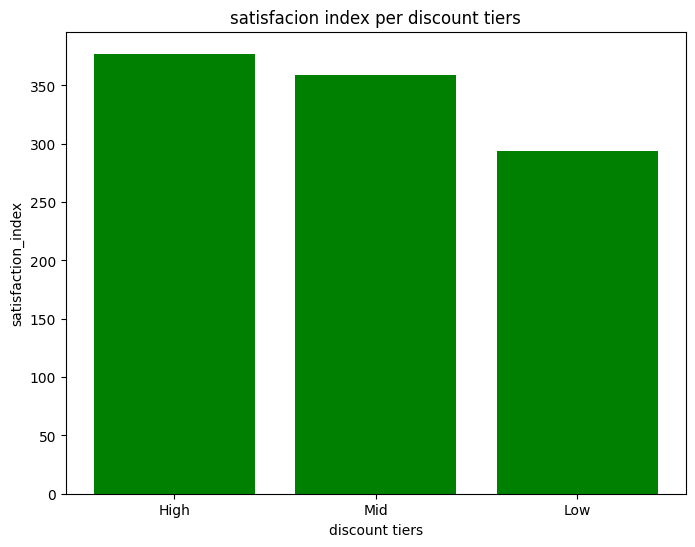

In [35]:
fig, ax = plt.subplots( figsize = (8,6)) 
ax.bar(discount_effectiveness["discount_tier"], discount_effectiveness["satisfactory_index"],color = "green")
ax.set_ylabel("satisfaction_index") 
ax.set_xlabel("discount tiers") 
ax.set_title("satisfacion index per discount tiers") 

plt.show()

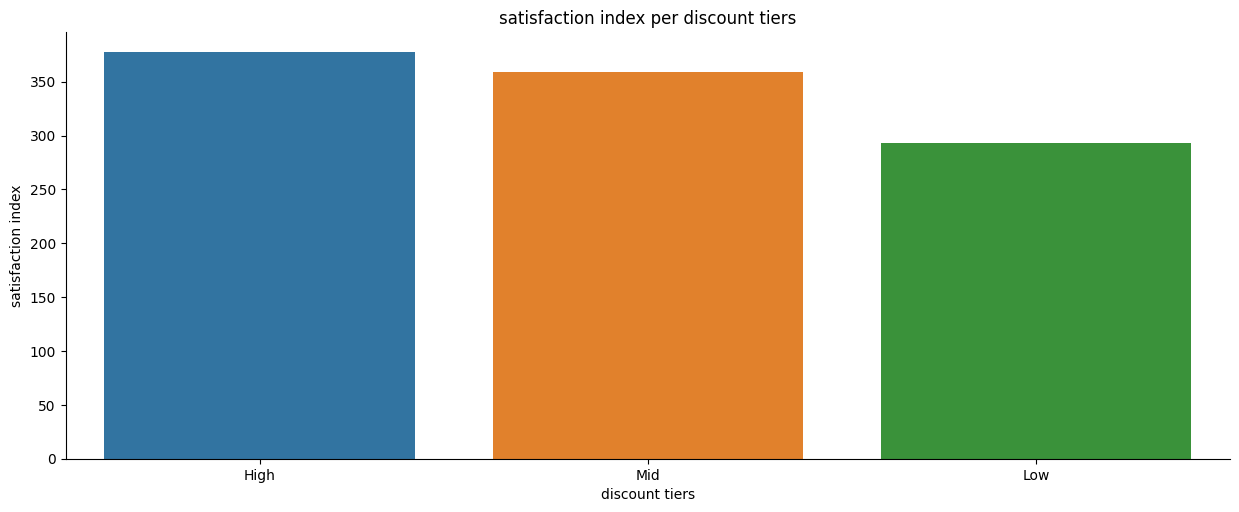

In [40]:
sns.catplot(
    y="satisfactory_index", 
    x="discount_tier", 
    hue="discount_tier", 
    data=discount_effectiveness, 
    aspect=2.5, 
    kind="bar"
)
plt.xlabel("discount tiers")
plt.ylabel("satisfaction index")
plt.title("satisfaction index per discount tiers") 
plt.show()


### 5) Ultra-Discount Deep Dive

Goal: Audit extreme cases (>90% discount).

Analysis:

- Export all ultra_discount == True.

- avg_rating, satisfaction_index, 

- frequency by brand/category.

Deliverables:

CSV: reports/ultra_discount_cases.csv

Bar: ultra-discount products satisfaction vs normal products

Narration line:
“These ultra-discount products are often one-time clearance items, dragging down brand trust.”

In [41]:
# Discount >90% saved within a variable called ultra_discnt   
ultra_discnt = df_3.query("ultra_discount == True")

In [48]:
# Average ratings & ratings distribution of ultra_discount across brands
ultra_disc_summary = (ultra_discnt.groupby("brands")
            .agg(mean_rating =("rating", "mean"), total_rating =("rating_count", "sum"),
                total_ultra_disct = ("ultra_discount", "count"),total_satisfied=("sentiment_value", lambda x: (x == 1).sum()))
            .sort_values("total_ultra_disct", ascending = False).reset_index()
)            

ultra_disc_summary


,brands,mean_rating,total_rating,total_ultra_disct,total_satisfied
0,Fire-Boltt,4.2,69685.0,5,0
1,rts,4.3,4426.0,1,0


In [37]:
brands_frequency = ultra_discnt["category"].value_counts()
brands_frequency

category
Electronics              5
Computers&Accessories    1
Name: count, dtype: int64

In [38]:
category_frequency = ultra_discnt["category"].value_counts()
category_frequency

category
Electronics              5
Computers&Accessories    1
Name: count, dtype: int64

In [50]:
df_3.to_csv("ultra_disc_summary.csv", index=False)

### 6) Sentiment Analytics

**Goal: compute the satisfaction and dissatisfaction rate against the total sentiment**

This tells us what brands and category satisfies the most customers and which doesnt

**Workflow**

- brands satisfaction % and dissatisfaction %

- category satisfaction% and dissatisfaction %

**Deliverables:**

- CSV: reports/final_sentiment_analysis.csv

- scatter plot of satisfaction rate 

- Heatmap: satisfaction rate vs disatisfaction rate  

In [51]:
category_sentiment = df_3.groupby("category").agg(total_satisfied=("sentiment_value", lambda x: (x == 1).sum()),
                                    total_sentiment = ("sentiment_value", "count")).query("total_sentiment >= 10")

sat_percent = category_sentiment["total_satisfied"] / category_sentiment["total_sentiment"]*100

category_sentiment["satisfied_%"] = sat_percent
category_sentiment.sort_values("satisfied_%", ascending=False)


,total_satisfied,total_sentiment,satisfied_%
category,,,
OfficeProducts,22,30,73.333333
Computers&Accessories,291,448,64.955357
Home&Kitchen,258,437,59.038902
Electronics,226,521,43.378119


In [52]:
brand_sentiment = df_3.groupby("brands").agg(total_satisfied=("sentiment_value", lambda x: (x == 1).sum()),
                                    total_sentiment = ("sentiment_value", "count")).query("total_sentiment >= 10")

sat_percent = brand_sentiment["total_satisfied"] / brand_sentiment["total_sentiment"]*100

brand_sentiment["satisfied_%"] = sat_percent
brand_sentiment.sort_values("satisfied_%", ascending=False)


,total_satisfied,total_sentiment,satisfied_%
brands,,,
pTron,13,13,100.000000
Classmate,9,11,81.818182
STRIFF,9,11,81.818182
AmazonBasics,25,33,75.757576
Duracell,15,20,75.000000
Lifelong,9,12,75.000000
AGARO,10,14,71.428571
Noise,17,24,70.833333
Wayona,17,24,70.833333
